# 🧠 Number Recognition with CNN (MNIST)

## 1. Title & Introduction

This notebook demonstrates **Handwritten Digit Recognition** using a **Convolutional Neural Network (CNN)**.

**Problem Statement**: Given an image of a handwritten digit (0–9), predict the digit.

- **Dataset**: [MNIST Dataset](http://yann.lecun.com/exdb/mnist/) (60,000 training + 10,000 testing grayscale images (28x28 pixels) of digits 0–9).
- **Why CNNs?** CNNs are designed for image tasks because they:
  - Exploit **local spatial patterns** (nearby pixels are related).
  - Are **translation invariant** (detect features anywhere).
  - Require fewer parameters than fully connected networks.


## 2. Theory

### Convolution
- Filters (kernels) slide across the image.
- Capture local patterns like edges, corners.

### Pooling
- Downsamples feature maps.
- **MaxPooling** keeps strongest feature, provides translation invariance.

### ReLU Activation
- $f(x) = \max(0, x)$
- Adds non-linearity, avoids vanishing gradient problems.

### Fully Connected Layers
- Flatten features, connect to output neurons.
- Last layer outputs class scores.

### Softmax + CrossEntropy
- Softmax converts scores to probabilities.
- CrossEntropy measures difference between prediction and target.


## 3. Dataset Preparation

We use **PyTorch torchvision.datasets.MNIST** to load the dataset.

- MNIST: Handwritten digits (0–9), grayscale, 28x28 pixels.
- Training: 60,000 images. Testing: 10,000 images.
- Images are normalized to [-1, 1] before training.


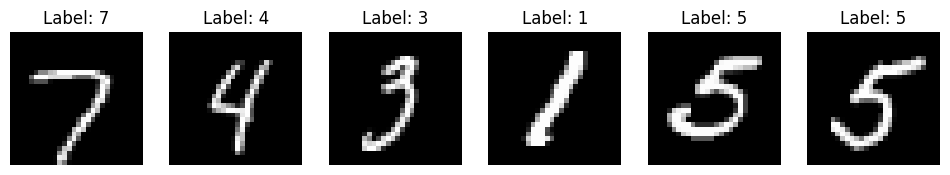

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=1000, shuffle=False)

# Show sample images
import matplotlib.pyplot as plt
images, labels = next(iter(trainloader))
fig, axes = plt.subplots(1,6, figsize=(12,2))
for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis("off")
plt.show()

## 4. CNN Model Architecture

We define a CNN with two convolutional layers, pooling, and two fully connected layers.

#### Model:
- Conv1: 1 → 32 filters (3x3), ReLU
- Conv2: 32 → 64 filters (3x3), ReLU
- MaxPooling: 2x2
- Flatten
- FC1: 64*12*12 → 128, ReLU
- FC2: 128 → 10 (class scores)
- Softmax via CrossEntropy


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  # 28x28 -> 26x26
        self.conv2 = nn.Conv2d(32, 64, 3, 1) # 26x26 -> 24x24
        self.pool = nn.MaxPool2d(2,2)        # -> 12x12
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = DigitCNN()
print(model)

DigitCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## 5. Training
We train the model using Adam optimizer and CrossEntropy loss.
- Optimizer: Adam (lr=0.001)
- Loss: CrossEntropy
- Epochs: 5–10 typical


In [3]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
train_losses, train_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_losses.append(running_loss/len(trainloader))
    train_accuracies.append(100*correct/total)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Acc: {train_accuracies[-1]:.2f}%")

Epoch 1/5, Loss: 0.1460, Acc: 95.62%
Epoch 2/5, Loss: 0.0422, Acc: 98.69%
Epoch 3/5, Loss: 0.0265, Acc: 99.16%
Epoch 4/5, Loss: 0.0176, Acc: 99.45%
Epoch 5/5, Loss: 0.0135, Acc: 99.57%


## 6. Evaluation
Test accuracy on unseen data.


In [4]:
model.eval()
correct, total, test_loss = 0, 0, 0.0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
test_acc = 100 * correct / total
print(f"Test Loss: {test_loss/len(testloader):.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.0447, Test Accuracy: 98.61%


## 7. Learning Curves
Plot training loss and accuracy across epochs.


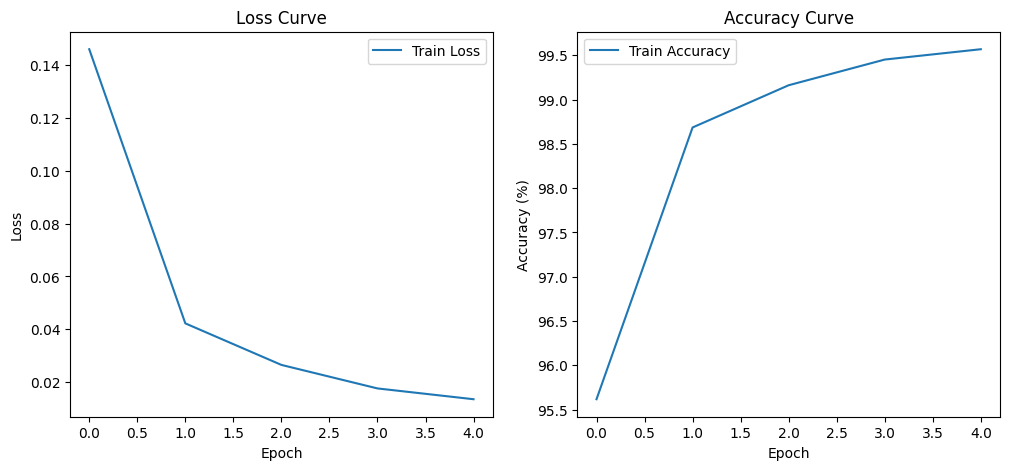

In [5]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curve'); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Accuracy Curve'); plt.legend()
plt.show()

## 8. Model Saving & Loading
Save and reload trained models to avoid retraining every time.


In [6]:
torch.save(model.state_dict(), "digit_cnn.pth")
print("Model saved as digit_cnn.pth")

new_model = DigitCNN()
new_model.load_state_dict(torch.load("digit_cnn.pth"))
new_model.eval()
print("Model loaded and ready for inference")

Model saved as digit_cnn.pth
Model loaded and ready for inference


C:\Users\zeelp\AppData\Local\Temp\ipykernel_12328\100629656.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load("digit_cnn.pth"))


## 9. Conclusion & References

- Achieved high accuracy (~98%) on MNIST.
- CNNs learn features hierarchically: edges → shapes → digits.
- Next steps: try deeper networks, batch normalization, dropout, or other datasets (CIFAR-10).

### References
- [MNIST Dataset](http://yann.lecun.com/exdb/mnist/)
- [PyTorch Docs](https://pytorch.org/docs/stable/index.html)
- [Brandon Rohrer – How CNNs Work](https://e2eml.school/how_convolutional_neural_networks_work.html)
- [3Blue1Brown – Neural Networks](https://www.3blue1brown.com/topics/neural-networks)
